# Personality Detection from Face Videos using PolyFace
Notebook ini berisi implementasi model untuk memprediksi trait kepribadian OCEAN (Openness, Conscientiousness, Extraversion, Agreeableness, Neuroticism) dari video wajah menggunakan PolyFace dan LSTM.

## README
#### Notebook ini digunakan untuk memprediksi kepribadian berdasarkan citra wajah menggunakan pendekatan transfer learning model PolyFace. Model dilatih untuk menghasilkan skor kepribadian berdasarkan lima dimensi OCEAN (Openness, Conscientiousness, Extraversion, Agreeableness, Neuroticism).

#### Hal yang perlu diperhatikan:
1. Persiapkan data preparation yang diperlukan
2. Instalasi library
3. Sesuaikan Path dataset
4. Pada tahap 7 (evaluation), rubah weights sesuai folder yang telah terbuat saat menjalankan training
5. Pada tahap 8 (history graph), rubah timestamp sesuai pada folder weights sebelumnya

# Default Training Flow

## 1. Setup Awal

In [1]:
# Import library yang diperlukan
import tensorflow as tf
from tensorflow import keras
from keras import Model, Input
from keras import layers
from keras.layers import Dense, Dropout, TimeDistributed, Reshape, Multiply, Activation, Lambda, LSTM
# import keras.backend as K
# import tensorflow_addons as tfa
import numpy as np
import datetime
import os
import torch
from pathlib import Path
from sklearn.metrics import mean_absolute_error
from polyfacemodels2 import create_model_polyface3, wrap_polyface_tf
from EfficientPolyFace import apolynet_stodepth_deeper

# Konfigurasi untuk reproduktibilitas
os.environ["TF_USE_CUDNN_RNN"] = "0"
tf.config.run_functions_eagerly(True)
tf.random.set_seed(42)
np.random.seed(42)

# Cek ketersediaan GPU untuk pytorch
print(torch.cuda.get_device_name())
print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)

# Cek ketersediaan GPU untuk TensorFlow
print("Devices:", tf.config.list_physical_devices())
print("GPU Available:", tf.config.list_physical_devices('GPU'))
print("TensorFlow version:", tf.__version__)
print("Keras version:", tf.keras.__version__)

NVIDIA GeForce RTX 5070
Torch: 2.7.1+cu128
CUDA available: True
CUDA version: 12.8
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.10.0
Keras version: 2.10.0


## 2. Memuat Dataset

In [2]:
train_ds = tf.data.Dataset.load('./data/videoface_all/train_ds') \
    .cache().shuffle(buffer_size=1000, seed=42).prefetch(buffer_size=tf.data.AUTOTUNE)

valid_ds = tf.data.Dataset.load('./data/videoface_all/val_ds') \
    .cache().shuffle(buffer_size=1000, seed=42).prefetch(buffer_size=tf.data.AUTOTUNE)

train_ds, valid_ds

c:\Users\USER\anaconda3\envs\polyface-3\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 10, 112, 112, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 10, 112, 112, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>)

## 3. Mencetak Model PolyFace


In [3]:
polyface112 = create_model_polyface3()
polyface112.trainable = False

# Simple print of the model architecture
print(polyface112)

# More detailed layer information
print("\nDetailed Layers:")
for name, module in polyface112.named_modules():
    if name:  # Skip empty name for the root module
        print(f"{name}: {module}")

PolyFace3(
  (backbone): APolynet(
    (stem): Stem(
      (step1): Step1(
        (stem): Sequential(
          (0): BasicConv2d(
            (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
            (bn): BatchNorm2d(32, eps=1e-10, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU(inplace=True)
          )
          (1): BasicConv2d(
            (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
            (bn): BatchNorm2d(32, eps=1e-10, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU(inplace=True)
          )
          (2): BasicConv2d(
            (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn): BatchNorm2d(64, eps=1e-10, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU(inplace=True)
          )
        )
        (branch0): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  

## 4. Build Model

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_video (InputLayer)    [(None, 10, 112, 112, 3)  0         
                             ]                                   
                                                                 
 polyface112 (TimeDistribute  (None, 10, 256)          0         
 d)                                                              
                                                                 
 lstm (LSTM)                 (None, 10, 128)           197120    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1024)              6656

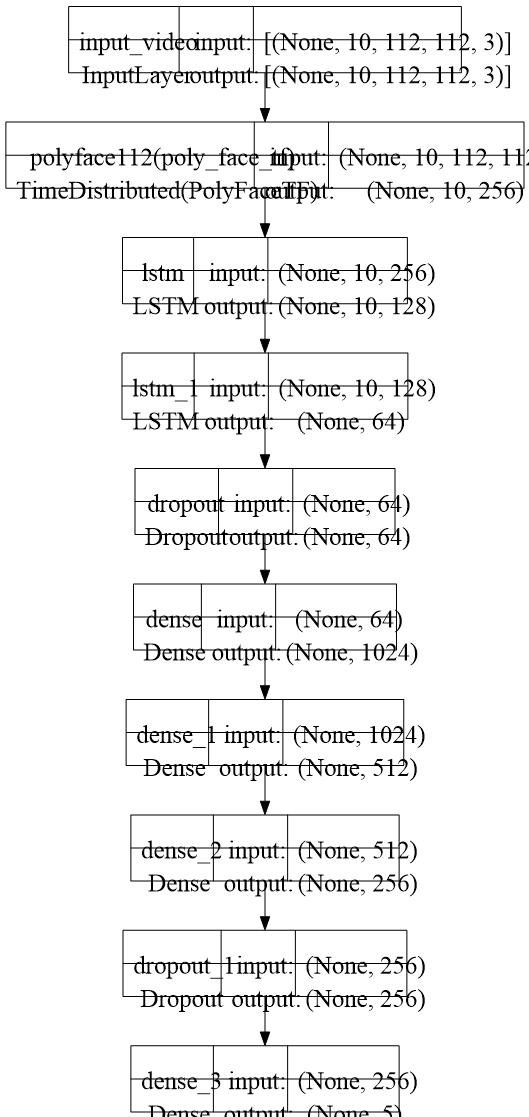

In [ ]:
from keras import layers, models

polyface_model_tf = wrap_polyface_tf(create_model_polyface3())
polyface_tflayer= polyface_model_tf.layers[-1]  # ambil layer-nya
polyface_tflayer.trainable = False  # freeze weights

# Input shape: 10 frames of 112x112x3
x_input = layers.Input(shape=(10, 112, 112, 3), name='input_video')

# Apply PolyFace feature extractor to each frame

x = layers.TimeDistributed(polyface_tflayer, name='polyface112')(x_input)

# LSTM untuk urutan fitur
x = layers.LSTM(units=128, return_sequences=True)(x)
x = layers.LSTM(units=64)(x)

# Dense layers dengan regulasi dan dropout
x = layers.Dropout(0.2)(x)
x = layers.Dense(units=1024)(x)
x = layers.Dense(units=512, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)

# Output layer untuk prediksi 5 dimensi (OCEAN traits)
outputs = layers.Dense(5, activation='sigmoid')(x)

# Build the model
model = models.Model(inputs=x_input, outputs=outputs)

# Visualisasi arsitektur model
model.summary()
keras.utils.plot_model(model, show_shapes=True)

## 5. Compile Model

In [5]:
# Timestamp unik
t = datetime.datetime.now().strftime("%m%d_%H%M%S")

# Optimizer
optimizer = keras.optimizers.Adagrad()

# Ganti nama folder
checkpoint_dir = f'./weights/polyface/{t}/'
os.makedirs(checkpoint_dir, exist_ok=True)

# Callbacks
early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True,
    verbose=1
)

check_point = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'polyface.t5'),
    monitor='val_mae',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

# Compile model
model.compile(
    optimizer=optimizer,
    loss='mse',
    metrics=['mae']
)

print(f"[INFO] Model dikompilasi dengan '{optimizer._name}' optimizer. "
      f"Checkpoint disimpan di '{checkpoint_dir}polyface.t5'")

[INFO] Model dikompilasi dengan 'Adagrad' optimizer. Checkpoint disimpan di './weights/polyface/1124_171024/polyface.t5'


## 6. Training

In [ ]:
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    batch_size=8,
    epochs=100,
    callbacks=[early_stopping, check_point],
    verbose=1,
)
# 1121_143746 polyfacemodels2 1595m 1.5s (26h 35m 1.5s)
# 1124_171024 polyfacemodels2 1545m 39.5s (25h 45m 39.5s)

Epoch 1/100
750/750 [==============================] - ETA: 0s - loss: 0.2254 - mae: 0.4744
Epoch 1: val_mae improved from inf to 0.44812, saving model to ./weights/polyface/1124_171024\polyface.t5
750/750 [==============================] - 1021s 1s/step - loss: 0.2254 - mae: 0.4744 - val_loss: 0.2009 - val_mae: 0.4481
Epoch 2/100
750/750 [==============================] - ETA: 0s - loss: 0.1677 - mae: 0.4077
Epoch 2: val_mae improved from 0.44812 to 0.34999, saving model to ./weights/polyface/1124_171024\polyface.t5
750/750 [==============================] - 911s 1s/step - loss: 0.1677 - mae: 0.4077 - val_loss: 0.1228 - val_mae: 0.3500
Epoch 3/100
750/750 [==============================] - ETA: 0s - loss: 0.0771 - mae: 0.2690
Epoch 3: val_mae improved from 0.34999 to 0.18198, saving model to ./weights/polyface/1124_171024\polyface.t5
750/750 [==============================] - 896s 1s/step - loss: 0.0771 - mae: 0.2690 - val_loss: 0.0334 - val_mae: 0.1820
Epoch 4/100
750/750 [==========

## 7. History Graph

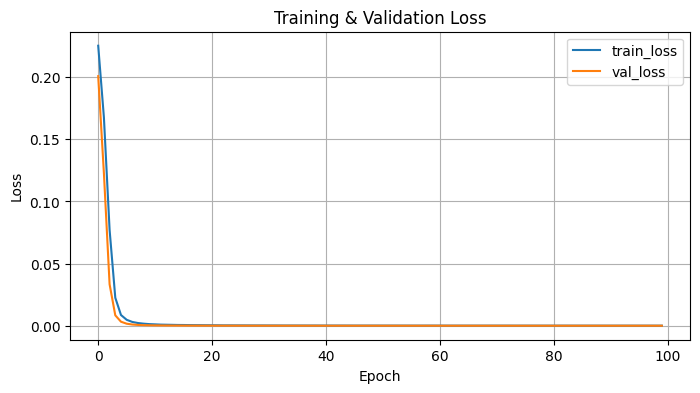

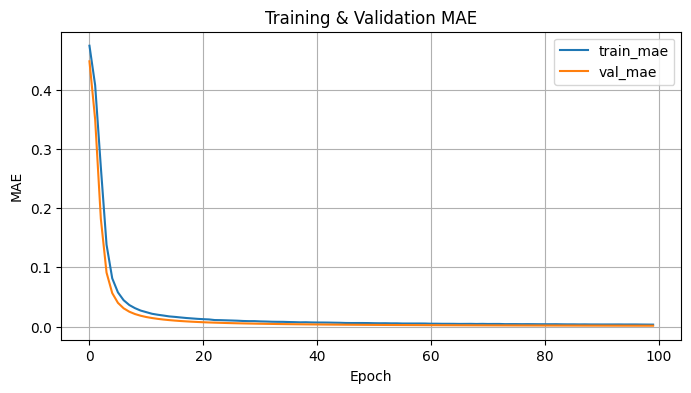

In [7]:
import matplotlib.pyplot as plt

# 1) Plot Loss
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'],    label='train_loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# 2) Plot MAE (atau metric lain yang kamu pakai)
plt.figure(figsize=(8,4))
plt.plot(history.history['mae'],     label='train_mae')
plt.plot(history.history['val_mae'], label='val_mae')
plt.title('Training & Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()

# Save Model

In [8]:
model.load_weights('./weights/polyface/1124_171024/polyface.t5')

In [ ]:
save_dir = r".\saved\polyface_adagrad"
model.save(save_dir)
print(f"Model berhasil disimpan di: {save_dir}")

## 8. Evaluation

In [9]:
# -------------------------
# Custom Accuracy Functions
# -------------------------
def acc(y_true, y_pred):
    mae = tf.reduce_mean(tf.abs(y_true - y_pred))
    accuracy = (1-mae)*100

    return accuracy

def acc_per_trait_and_mean(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred, multioutput='raw_values')
    acc_per_trait = (1 - mae) * 100
    mean_acc = (1 - np.mean(mae)) * 100
    return acc_per_trait, mean_acc

In [10]:
# -------------------------
# Load Dataset
# -------------------------
train_ds = tf.data.Dataset.load('./data/videoface_all/train_ds')
valid_ds = tf.data.Dataset.load('./data/videoface_all/val_ds')
test_ds  = tf.data.Dataset.load('./data/videoface_all/test_ds')

c:\Users\USER\anaconda3\envs\polyface-3\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Training data

In [11]:
loss, mae = model.evaluate(train_ds)
acc

750/750 [==============================] - 710s 947ms/step - loss: 2.0657e-06 - mae: 0.0014


<function __main__.acc(y_true, y_pred)>

In [12]:
y_true = np.concatenate([y for x,y in train_ds])
y_pred = model.predict(train_ds)

acc_per_trait, mean_acc = acc_per_trait_and_mean(y_true, y_pred)

acc_per_trait, mean_acc


750/750 [==============================] - 707s 943ms/step


(array([99.87045 , 99.85232 , 99.857056, 99.842766, 99.86037 ],
       dtype=float32),
 99.85659330850467)

Validation data

In [13]:
loss, mae = model.evaluate(valid_ds)
acc

250/250 [==============================] - 232s 928ms/step - loss: 2.0691e-06 - mae: 0.0014


<function __main__.acc(y_true, y_pred)>

In [14]:
y_true = np.concatenate([y for x,y in valid_ds])
y_pred = model.predict(valid_ds)

mae = mean_absolute_error(y_true, y_pred, multioutput='raw_values')
(1-mae)*100, (1-np.mean(mae))*100

250/250 [==============================] - 237s 946ms/step


(array([99.870346, 99.852196, 99.85693 , 99.842636, 99.86026 ],
       dtype=float32),
 99.85647769644856)

Test data

In [15]:
loss, mae = model.evaluate(test_ds)
acc

250/250 [==============================] - 233s 933ms/step - loss: 2.0681e-06 - mae: 0.0014


<function __main__.acc(y_true, y_pred)>

In [16]:
y_true = np.concatenate([y for x,y in test_ds])
y_pred = model.predict(test_ds)

acc_per_trait, mean_acc = acc_per_trait_and_mean(y_true, y_pred)

acc_per_trait, mean_acc

250/250 [==============================] - 233s 932ms/step


(array([99.87038 , 99.852234, 99.856964, 99.84268 , 99.86029 ],
       dtype=float32),
 99.85650995513424)

# Training Flow with Regulizer L2

## 1. Setup Awal

In [1]:
# Import library yang diperlukan
import tensorflow as tf
from tensorflow import keras
from keras import Model, Input
from keras import layers
from keras.layers import Dense, Dropout, TimeDistributed, Reshape, Multiply, Activation, Lambda, LSTM
# import keras.backend as K
# import tensorflow_addons as tfa
import numpy as np
import datetime
import os
import torch
from pathlib import Path
from sklearn.metrics import mean_absolute_error
from polyfacemodels2 import create_model_polyface3, wrap_polyface_tf
from EfficientPolyFace import apolynet_stodepth_deeper

# Konfigurasi untuk reproduktibilitas
os.environ["TF_USE_CUDNN_RNN"] = "0"
tf.config.run_functions_eagerly(True)
tf.random.set_seed(42)
np.random.seed(42)

# Cek ketersediaan GPU untuk pytorch
print(torch.cuda.get_device_name())
print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)

# Cek ketersediaan GPU untuk TensorFlow
print("Devices:", tf.config.list_physical_devices())
print("GPU Available:", tf.config.list_physical_devices('GPU'))
print("TensorFlow version:", tf.__version__)
print("Keras version:", tf.keras.__version__)

NVIDIA GeForce RTX 5070
Torch: 2.7.1+cu128
CUDA available: True
CUDA version: 12.8
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.10.0
Keras version: 2.10.0


## 2. Memuat Dataset

In [2]:
train_ds = tf.data.Dataset.load('./data/videoface_all/train_ds') \
    .cache().shuffle(buffer_size=1000, seed=42).prefetch(buffer_size=tf.data.AUTOTUNE)

valid_ds = tf.data.Dataset.load('./data/videoface_all/val_ds') \
    .cache().shuffle(buffer_size=1000, seed=42).prefetch(buffer_size=tf.data.AUTOTUNE)

train_ds, valid_ds

c:\Users\USER\anaconda3\envs\polyface-3\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 10, 112, 112, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 10, 112, 112, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>)

## 3. Mencetak Model PolyFace


In [3]:
polyface112 = create_model_polyface3()
polyface112.trainable = False

# Simple print of the model architecture
print(polyface112)

# More detailed layer information
print("\nDetailed Layers:")
for name, module in polyface112.named_modules():
    if name:  # Skip empty name for the root module
        print(f"{name}: {module}")

PolyFace3(
  (backbone): APolynet(
    (stem): Stem(
      (step1): Step1(
        (stem): Sequential(
          (0): BasicConv2d(
            (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
            (bn): BatchNorm2d(32, eps=1e-10, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU(inplace=True)
          )
          (1): BasicConv2d(
            (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
            (bn): BatchNorm2d(32, eps=1e-10, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU(inplace=True)
          )
          (2): BasicConv2d(
            (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn): BatchNorm2d(64, eps=1e-10, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU(inplace=True)
          )
        )
        (branch0): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  

## 4. Build Model

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_video (InputLayer)    [(None, 10, 112, 112, 3)  0         
                             ]                                   
                                                                 
 polyface112 (TimeDistribute  (None, 10, 256)          0         
 d)                                                              
                                                                 
 lstm (LSTM)                 (None, 10, 128)           197120    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 1024)              66560     
                                                                 
 dropout (Dropout)           (None, 1024)              0   

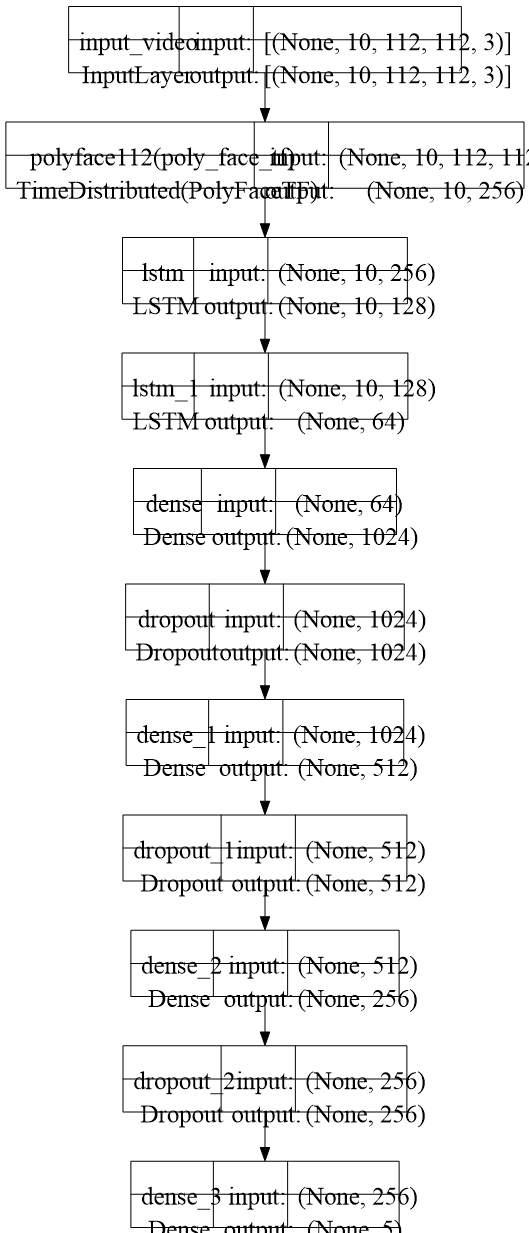

In [4]:
from keras import layers, models, regularizers

polyface_model_tf = wrap_polyface_tf(create_model_polyface3())
polyface_tflayer= polyface_model_tf.layers[-1]  # ambil layer-nya
polyface_tflayer.trainable = False  # freeze weights

# Input shape: 10 frames of 112x112x3
x_input = layers.Input(shape=(10, 112, 112, 3), name='input_video')

# Apply PolyFace feature extractor to each frame

x = layers.TimeDistributed(polyface_tflayer, name='polyface112')(x_input)

# LSTM untuk urutan fitur
x = layers.LSTM(units=128, return_sequences=True)(x)
x = layers.LSTM(units=64)(x)

# Dense layers dengan regulasi dan dropout
x = layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.Dropout(0.5)(x)

# Output layer untuk prediksi 5 dimensi (OCEAN traits)
outputs = layers.Dense(5, activation='sigmoid')(x)

# Build the model
model = models.Model(inputs=x_input, outputs=outputs)

# Visualisasi arsitektur model
model.summary()
keras.utils.plot_model(model, show_shapes=True)

## 5. Compile Model

In [5]:
# Timestamp unik
t = datetime.datetime.now().strftime("%m%d_%H%M%S")

# Optimizer
optimizer = keras.optimizers.Adagrad()

# Ganti nama folder
checkpoint_dir = f'./weights/polyface/{t}/'
os.makedirs(checkpoint_dir, exist_ok=True)

# Callbacks
early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True,
    verbose=1
)

check_point = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'polyface.t5'),
    monitor='val_mae',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

# Compile model
model.compile(
    optimizer=optimizer,
    loss='mse',
    metrics=['mae']
)

print(f"[INFO] Model dikompilasi dengan '{optimizer._name}' optimizer. "
      f"Checkpoint disimpan di '{checkpoint_dir}polyface.t5'")

[INFO] Model dikompilasi dengan 'Adagrad' optimizer. Checkpoint disimpan di './weights/polyface/1127_145313/polyface.t5'


## 6. Training

In [ ]:
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    batch_size=8,
    epochs=100,
    callbacks=[early_stopping, check_point],
    verbose=1,
)
# 1127_145313 polyfacemodels2 1506m 44.1s (25h 6m 44.1s)

Epoch 1/100
750/750 [==============================] - ETA: 0s - loss: 11.1495 - mae: 0.4754
Epoch 1: val_mae improved from inf to 0.45210, saving model to ./weights/polyface/1127_145313\polyface.t5
750/750 [==============================] - 1400s 1s/step - loss: 11.1495 - mae: 0.4754 - val_loss: 10.6190 - val_mae: 0.4521
Epoch 2/100
750/750 [==============================] - ETA: 0s - loss: 10.1240 - mae: 0.4282
Epoch 2: val_mae improved from 0.45210 to 0.39789, saving model to ./weights/polyface/1127_145313\polyface.t5
750/750 [==============================] - 891s 1s/step - loss: 10.1240 - mae: 0.4282 - val_loss: 9.6384 - val_mae: 0.3979
Epoch 3/100
750/750 [==============================] - ETA: 0s - loss: 9.1841 - mae: 0.3633
Epoch 3: val_mae improved from 0.39789 to 0.31804, saving model to ./weights/polyface/1127_145313\polyface.t5
750/750 [==============================] - 852s 1s/step - loss: 9.1841 - mae: 0.3633 - val_loss: 8.7359 - val_mae: 0.3180
Epoch 4/100
750/750 [=====

## 7. History Graph

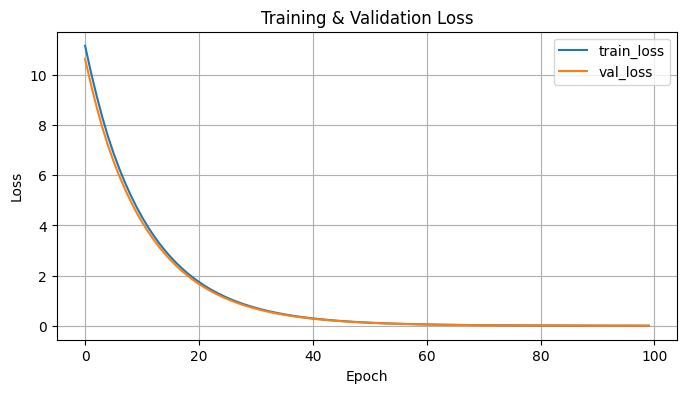

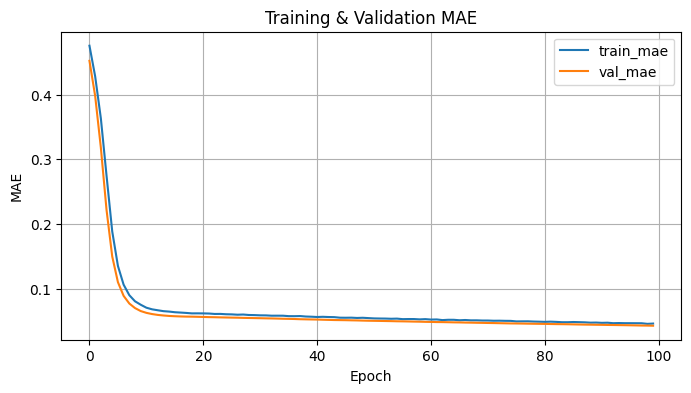

In [7]:
import matplotlib.pyplot as plt

# 1) Plot Loss
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'],    label='train_loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# 2) Plot MAE (atau metric lain yang kamu pakai)
plt.figure(figsize=(8,4))
plt.plot(history.history['mae'],     label='train_mae')
plt.plot(history.history['val_mae'], label='val_mae')
plt.title('Training & Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()

# Save Model

In [8]:
model.load_weights('./weights/polyface/1127_145313/polyface.t5')

In [9]:
save_dir = r".\saved\polyface_adagrad"
model.save(save_dir)
print(f"Model berhasil disimpan di: {save_dir}")

INFO:tensorflow:Assets written to: .\saved\polyface_adagrad\assets


INFO:tensorflow:Assets written to: .\saved\polyface_adagrad\assets


Model berhasil disimpan di: .\saved\polyface_adagrad


## 8. Evaluation

In [10]:
# -------------------------
# Custom Accuracy Functions
# -------------------------
def acc(y_true, y_pred):
    mae = tf.reduce_mean(tf.abs(y_true - y_pred))
    accuracy = (1-mae)*100

    return accuracy

def acc_per_trait_and_mean(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred, multioutput='raw_values')
    acc_per_trait = (1 - mae) * 100
    mean_acc = (1 - np.mean(mae)) * 100
    return acc_per_trait, mean_acc

In [11]:
# -------------------------
# Load Dataset
# -------------------------
train_ds = tf.data.Dataset.load('./data/videoface_all/train_ds')
valid_ds = tf.data.Dataset.load('./data/videoface_all/val_ds')
test_ds  = tf.data.Dataset.load('./data/videoface_all/test_ds')

c:\Users\USER\anaconda3\envs\polyface-3\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Training data

In [12]:
loss, mae = model.evaluate(train_ds)
acc

750/750 [==============================] - 683s 910ms/step - loss: 0.0084 - mae: 0.0428


<function __main__.acc(y_true, y_pred)>

In [13]:
y_true = np.concatenate([y for x,y in train_ds])
y_pred = model.predict(train_ds)

acc_per_trait, mean_acc = acc_per_trait_and_mean(y_true, y_pred)

acc_per_trait, mean_acc


750/750 [==============================] - 684s 911ms/step


(array([95.78321 , 95.628914, 95.72445 , 95.693726, 95.77179 ],
       dtype=float32),
 95.72041667997837)

Validation data

In [14]:
loss, mae = model.evaluate(valid_ds)
acc

250/250 [==============================] - 229s 916ms/step - loss: 0.0084 - mae: 0.0428


<function __main__.acc(y_true, y_pred)>

In [15]:
y_true = np.concatenate([y for x,y in valid_ds])
y_pred = model.predict(valid_ds)

mae = mean_absolute_error(y_true, y_pred, multioutput='raw_values')
(1-mae)*100, (1-np.mean(mae))*100

250/250 [==============================] - 226s 901ms/step


(array([95.78314 , 95.628845, 95.724365, 95.69365 , 95.77172 ],
       dtype=float32),
 95.72034254670143)

Test data

In [16]:
loss, mae = model.evaluate(test_ds)
acc

250/250 [==============================] - 230s 919ms/step - loss: 0.0084 - mae: 0.0428


<function __main__.acc(y_true, y_pred)>

In [17]:
y_true = np.concatenate([y for x,y in test_ds])
y_pred = model.predict(test_ds)

acc_per_trait, mean_acc = acc_per_trait_and_mean(y_true, y_pred)

acc_per_trait, mean_acc

250/250 [==============================] - 225s 901ms/step


(array([95.78314 , 95.62886 , 95.72438 , 95.693665, 95.77172 ],
       dtype=float32),
 95.72035633027554)